In [1]:
from collections import defaultdict
from utils import parse_midas_data, sample_utils as su
import numpy

species_name = 'Bacteroides_vulgatus_57955'
sample = '700116611'
samples, sfs_map = parse_midas_data.parse_within_sample_sfs(species_name, allowed_variant_types=set(['4D']))

In [36]:
freq_counts = defaultdict(int)

for depth, alt in sfs_map[sample]:
    f = alt*1.0/depth
    n, _ = sfs_map[sample][(depth, alt)]
    freq_counts[f] += n

In [37]:
freqs = []

for freq in freq_counts:
    if freq > 0.5:
        new_freq = 1-freq
    else:
        new_freq = freq
    freqs += [new_freq] * freq_counts[freq]

In [5]:
from matplotlib import pyplot as plt
plt.hist(freqs, bins=50)
plt.show()

NameError: name 'freqs' is not defined

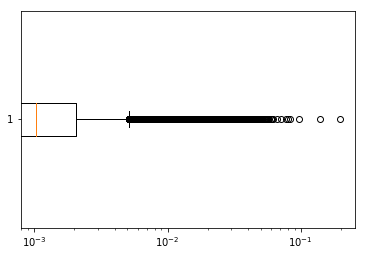

In [39]:
plt.xscale('log')
plt.boxplot(freqs, vert=False)
plt.show()

In [4]:
# Temporal changes
from utils import config, sample_utils as su, parse_midas_data
import numpy as np
from collections import defaultdict
import pickle

sweep_type = 'full'
ddir = '/u/home/d/daisyche/mother_infant/data/' # config.data_directory
pdir = "%s/pickles" % ddir

dNdS_distribution = pickle.load(open('%s/dNdS_distribution_%s.pkl' % (pdir, sweep_type), 'rb'))
species_snp_changes = pickle.load(open('%s/species_snp_changes_%s.pkl' % (pdir, sweep_type), 'rb'))
species_between_snp_changes = pickle.load(open('%s/species_between_snp_changes_%s.pkl' % (pdir, sweep_type), 'rb'))
species_gene_changes = pickle.load(open('%s/species_gene_changes_%s.pkl' % (pdir, sweep_type), 'rb'))
species_between_gene_changes = pickle.load(open('%s/species_between_gene_changes_%s.pkl' % (pdir, sweep_type), 'rb'))

In [5]:
mi_tp_sample_dict, infant_tp_labels = su.get_mi_tp_sample_dict(binned=True)

In [6]:
tp_pair_event_type_counts = {}

for cohort in species_snp_changes:
    for species in species_snp_changes[cohort]:
        for tp_pair in species_snp_changes[cohort][species]:     
            for num_snp_changes, perr, L in species_snp_changes[cohort][species][tp_pair]:            
                
                if num_snp_changes == 0:
                    event_type = 'no change'
                elif num_snp_changes < 20:
                    event_type = 'modification'
                elif num_snp_changes > 400:
                    event_type = 'replacement'
                else:
                    continue

In [7]:
def tp_to_category(tp_pair):
    tpa, tpb = tp_pair
    string = 'MI' if (tpa[0], tpb[0]) == ('I', 'M') else tpa[0]+tpb[0]
    return string

In [8]:
# Modeled after summarize_snv_changes.py

tp_types = ['MM', 'MI', 'II', 'AA']
event_types = ['no change', 'modification', 'replacement']
tp_type_event_type_counts = {tpt: {et: 0 for et in event_types} for tpt in tp_types}
tp_type_event_type_dNdS = {tpt: defaultdict(list) for tpt in tp_types}

opp_non_syn_ratio = []

desired_cohorts = species_snp_changes.keys()

for cohort in desired_cohorts:
    for species in species_snp_changes[cohort]:
        for tp_pair in species_snp_changes[cohort][species]:     
            for num_snp_changes, perr, L in species_snp_changes[cohort][species][tp_pair]:            
                
                if num_snp_changes == 0:
                    event_type = 'no change'
                elif num_snp_changes < 100:
                    event_type = 'modification'
                elif num_snp_changes > 400:
                    event_type = 'replacement'
                else:
                    continue
                
                tp_type = tp_to_category(tp_pair)
                tp_type_event_type_counts[tp_type][event_type] += 1
            
            try:
                diff1D, opp1D, diff4D, opp4D = dNdS_distribution[event_type][species][cohort][tp_pair]
            except:
                print("Weird...")
                print(cohort)
                print(tp_pair)                
                continue

            if opp1D == 0 or opp4D == 0:
                continue

            opp_non_syn_ratio.append(float(opp1D)/float(opp4D))
            dN = (diff1D+1)/(float(opp1D)+1)
            dS = (diff4D+1)/(float(opp4D)+1)
            tp_type_event_type_dNdS[tp_type][event_type].append(dN/dS)

Weird...
olm
frozenset(['I16', 'I18'])
Weird...
olm
frozenset(['I8', 'I26'])
Weird...
backhed
frozenset(['I3', 'I2'])
Weird...
shao
frozenset(['I7', 'I218.685'])
Weird...
shao
frozenset(['I284.565', 'I4'])


In [9]:
for tp_type in ['II', 'MI', 'MM', 'AA']:
    print(tp_type)
    print(tp_type_event_type_counts[tp_type])

II
{'modification': 160, 'no change': 2709, 'replacement': 147}
MI
{'modification': 58, 'no change': 124, 'replacement': 25}
MM
{'modification': 3, 'no change': 61, 'replacement': 3}
AA
{'modification': 65, 'no change': 925, 'replacement': 23}


In [10]:
np.mean(opp_non_syn_ratio)

4.214741953407262

In [11]:
# Normalize to get percentages
tp_type_event_type_counts_alt = {tpt: {} for tpt in tp_types}

for tp_type in tp_type_event_type_counts:
    total = 0
    for event_type in tp_type_event_type_counts[tp_type]:
        total += tp_type_event_type_counts[tp_type][event_type]
    if total == 0:
        continue
    for event_type in tp_type_event_type_counts[tp_type]:
        prop = tp_type_event_type_counts[tp_type][event_type]/float(total)
        tp_type_event_type_counts_alt[tp_type][event_type] = prop

In [12]:
tp_type_event_type_counts

{'AA': {'modification': 65, 'no change': 925, 'replacement': 23},
 'II': {'modification': 160, 'no change': 2709, 'replacement': 147},
 'MI': {'modification': 58, 'no change': 124, 'replacement': 25},
 'MM': {'modification': 3, 'no change': 61, 'replacement': 3}}

In [13]:
for tp_type in ['II', 'MI', 'MM', 'AA']:
    print(tp_type)
    print(tp_type_event_type_counts_alt[tp_type])

II
{'modification': 0.05305039787798409, 'no change': 0.898209549071618, 'replacement': 0.04874005305039788}
MI
{'modification': 0.28019323671497587, 'no change': 0.5990338164251208, 'replacement': 0.12077294685990338}
MM
{'modification': 0.04477611940298507, 'no change': 0.9104477611940298, 'replacement': 0.04477611940298507}
AA
{'modification': 0.06416584402764067, 'no change': 0.9131293188548865, 'replacement': 0.022704837117472853}


In [14]:
tp_type_event_type_dNdS_means = {tpt: {} for tpt in tp_types}

for tp_type in tp_type_event_type_dNdS:
    for event_type in tp_type_event_type_dNdS[tp_type]:
        mean_dNdS = np.mean(tp_type_event_type_dNdS[tp_type][event_type])
        tp_type_event_type_dNdS_means[tp_type][event_type] = mean_dNdS

In [15]:
tp_type_event_type_dNdS_means

{'AA': {'modification': 0.6790752417402612, 'no change': 0.2425547718609997},
 'II': {'modification': 0.46664964409014303,
  'no change': 0.24858761018103592,
  'replacement': 0.14167850593482248},
 'MI': {'modification': 0.4158073047626075,
  'no change': 0.2553981252528438,
  'replacement': 0.12858408133421498},
 'MM': {'modification': 0.2445137374680607,
  'no change': 0.24032720357233275,
  'replacement': 0.10979308100339141}}

In [16]:
# Compare full and partial
species_snp_changes_full = pickle.load(open('%s/species_snp_changes_%s.pkl' % (pdir, 'full'), 'rb'))
species_snp_changes_partial = pickle.load(open('%s/species_snp_changes_%s.pkl' % (pdir, 'partial'), 'rb'))

# Modeled after summarize_snv_changes.py

tp_types = ['MM', 'MI', 'II', 'AA']
event_types = ['no change', 'modification', 'replacement']

tp_type_event_type_counts_partial = {tpt: {et: 0 for et in event_types} for tpt in tp_types}
for cohort in species_snp_changes_partial:
    for species in species_snp_changes_partial[cohort]:
        for tp_pair in species_snp_changes_partial[cohort][species]:     
            for num_snp_changes, _, _ in species_snp_changes_partial[cohort][species][tp_pair]:
                if num_snp_changes == 0:
                    event_type = 'no change' # no change in terms of partial sweeps
                elif num_snp_changes < 100:
                    event_type = 'modification'
                elif num_snp_changes > 400:
                    event_type = 'replacement'
                else:
                    continue                
                tp_type = tp_to_category(tp_pair)
                tp_type_event_type_counts_partial[tp_type][event_type] += 1

tp_type_event_type_counts_full = {tpt: {et: 0 for et in event_types} for tpt in tp_types}
for cohort in species_snp_changes_full:
    for species in species_snp_changes_full[cohort]:
        for tp_pair in species_snp_changes_full[cohort][species]:     
            for num_snp_changes, _, _ in species_snp_changes_full[cohort][species][tp_pair]:
                if num_snp_changes == 0:
                    event_type = 'no change' # no change in terms of partial sweeps
                elif num_snp_changes < 100:
                    event_type = 'modification'
                elif num_snp_changes > 400:
                    event_type = 'replacement'
                else:
                    continue                
                tp_type = tp_to_category(tp_pair)
                tp_type_event_type_counts_full[tp_type][event_type] += 1

IOError: [Errno 2] No such file or directory: '/u/home/d/daisyche/mother_infant/data//pickles/species_snp_changes_partial.pkl'

In [18]:
tp_type_event_type_counts = {tpt: {} for tpt in tp_types}

for tp_type in tp_type_event_type_counts_partial:
    tp_type_event_type_counts[tp_type]['no change'] = tp_type_event_type_counts_partial[tp_type]['no change']
    tp_type_event_type_counts[tp_type]['mod-full'] = tp_type_event_type_counts_full[tp_type]['modification']
    tp_type_event_type_counts[tp_type]['mod-partial'] = tp_type_event_type_counts_partial[tp_type]['modification'] - tp_type_event_type_counts_full[tp_type]['modification']
    tp_type_event_type_counts[tp_type]['replacement'] = tp_type_event_type_counts_partial[tp_type]['replacement']

NameError: name 'tp_type_event_type_counts_partial' is not defined

In [62]:
tp_type_event_type_counts

{'AA': {'mod-full': 72,
  'mod-partial': 199,
  'no change': 681,
  'replacement': 23},
 'II': {'mod-full': 139,
  'mod-partial': 158,
  'no change': 1661,
  'replacement': 134},
 'MI': {'mod-full': 66, 'mod-partial': 29, 'no change': 76, 'replacement': 24},
 'MM': {'mod-full': 6, 'mod-partial': 20, 'no change': 38, 'replacement': 2}}

In [63]:
# Normalize to get percentages
tp_type_event_type_counts_alt = {tpt: {} for tpt in tp_types}

for tp_type in tp_type_event_type_counts:
    total = 0
    for event_type in tp_type_event_type_counts[tp_type]:
        total += tp_type_event_type_counts[tp_type][event_type]
    for event_type in tp_type_event_type_counts[tp_type]:
        prop = tp_type_event_type_counts[tp_type][event_type]/float(total)
        tp_type_event_type_counts_alt[tp_type][event_type] = prop

In [64]:
tp_type_event_type_counts_alt

{'AA': {'mod-full': 0.07384615384615385,
  'mod-partial': 0.2041025641025641,
  'no change': 0.6984615384615385,
  'replacement': 0.02358974358974359},
 'II': {'mod-full': 0.06644359464627152,
  'mod-partial': 0.07552581261950286,
  'no change': 0.7939770554493308,
  'replacement': 0.06405353728489484},
 'MI': {'mod-full': 0.3384615384615385,
  'mod-partial': 0.14871794871794872,
  'no change': 0.38974358974358975,
  'replacement': 0.12307692307692308},
 'MM': {'mod-full': 0.09090909090909091,
  'mod-partial': 0.30303030303030304,
  'no change': 0.5757575757575758,
  'replacement': 0.030303030303030304}}

In [17]:
# Survival plot

from utils import config
from matplotlib import pyplot as plt
import matplotlib.cm as cmx
import numpy
from math import exp, log

In [18]:
def calculate_unnormalized_survival_from_vector(counts):
	counts = sorted(counts)
	xs = []
	ns = []
	ns_cur = len(counts)
	min = -1
	for count in counts:
		if count > min:
			ns.append(ns_cur) # Number of elements greater or equal
			xs.append(count)
			min = count
		ns_cur -= 1
	xs.append(xs[len(xs)-1]+1)
	ns.append(0)
	return xs, numpy.array(ns)

In [19]:
fig_snp, ax_snp = plt.subplots(figsize=(5,3))

colormap = cmx.get_cmap('jet', 6)
colors = [colormap(x) for x in numpy.array([x for x in range(0,6)])/6.0]

modification_difference_threshold = config.modification_difference_threshold
replacement_difference_threshold = config.replacement_difference_threshold

# Unrelated mother/infant @
# Unrelated adult @
# Adult-adult @
# Mother-mother @
# Infant-infant @
# Mother-infant @

# Plot SNP change distribution

ax_snp.set_xscale('log')
ax_snp.set_yscale('log')
ax_snp.set_ylabel('Fraction comparisons $\geq n$', fontsize=11)
ax_snp.set_xlabel('# SNP changes', fontsize=11)

ax_snp.spines['top'].set_visible(False)
ax_snp.spines['right'].set_visible(False)
ax_snp.get_xaxis().tick_bottom()
ax_snp.get_yaxis().tick_left()

color_i = 0

In [21]:
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'olm', 'hmp']
mi_cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'olm']
pooled_snp_change_distribution = {cohort: defaultdict(list) for cohort in cohorts}
pooled_between_snp_change_distribution = {cohort: defaultdict(list) for cohort in cohorts}

for cohort in species_snp_changes:
    for species in species_snp_changes[cohort]:
        for tp_pair in species_snp_changes[cohort][species]:     
            for num_snp_changes, perr, L in species_snp_changes[cohort][species][tp_pair]:
                pooled_snp_change_distribution[cohort][tp_pair].append(num_snp_changes)

for cohort in species_between_snp_changes:
    for species in species_between_snp_changes[cohort]:
        for tp_pair in species_between_snp_changes[cohort][species]:     
            for num_snp_changes, perr, L in species_between_snp_changes[cohort][species][tp_pair]:
                pooled_between_snp_change_distribution[cohort][tp_pair].append(num_snp_changes)

In [22]:
ymin, ymax = 0.0001, 1.3
ax_snp.set_ylim([ymin,ymax])
xmin, xmax = 1e-01, 2e05
ax_snp.set_xlim([xmin, xmax])

# Now fill in the graphics

ax_snp.fill_between([xmin,1], [ymin,ymin],[ymax,ymax],color='0.8',zorder=1)
ax_snp.fill_between([1,modification_difference_threshold],[ymin,ymin],[ymax,ymax],color='#deebf7',zorder=1)
ax_snp.fill_between([replacement_difference_threshold,xmax],[ymin,ymin],[ymax,ymax],color='#fee0d2',zorder=1)

ax_snp.text( exp((log(1e05)+log(replacement_difference_threshold))/2), ymax*1.2, 'putative\nreplacement',fontsize=12,fontstyle='italic',ha='center',color='#fc9272',zorder=1)
ax_snp.text( exp((log(1)+log(modification_difference_threshold))/2), ymax*1.2, 'putative\nmodification',fontsize=12,fontstyle='italic',ha='center',color='#9ecae1',zorder=1)

# Unrelated adults
counts = []
for tp_pair in pooled_between_snp_change_distribution['hmp'].keys():
	counts += pooled_between_snp_change_distribution['hmp'][tp_pair]

xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated adults", where='pre',zorder=4)
color_i += 1

# Unrelated mother/infant
counts = []
for cohort in mi_cohorts:
	for tp_pair in pooled_between_snp_change_distribution[cohort].keys():
		counts += pooled_between_snp_change_distribution[cohort][tp_pair]

xs, ns = calculate_unnormalized_survival_from_vector(counts)
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label="Unrelated mothers/infants", where='pre',zorder=4)
color_i += 1

# Save
ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1)
fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_a1.png' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)

# Within-host, adult
counts = []
for tp_pair in pooled_snp_change_distribution['hmp'].keys():
	counts += pooled_snp_change_distribution['hmp'][tp_pair]

xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = 'HMP: Adult 6 months' + (' (n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Save
ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1)
fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_a2.png' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)

# Within-host, infant-infant
counts = []
for cohort in mi_cohorts:
	for tp_pair in pooled_snp_change_distribution[cohort].keys():
		tp1, tp2 = tp_pair
		if tp1[0] == 'I' and tp2[0] == 'I':
			counts += pooled_snp_change_distribution[cohort][tp_pair]

xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = "Infant-infant" + (' (n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

# Save
ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1)
fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_a3.png' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)

# Within-host, mother-infant
counts = []
for cohort in mi_cohorts:
	for tp_pair in pooled_snp_change_distribution[cohort].keys():
		tp1, tp2 = tp_pair
		if (tp1[0] == 'I' and tp2[0] == 'M') or (tp1[0] == 'M' and tp2[0] == 'I'):
			counts += pooled_snp_change_distribution[cohort][tp_pair]

xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = "Mother-infant" + (' (n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1

'''
# Within-host, mother-mother
counts = []
for cohort in mi_cohorts:
	for tp_pair in pooled_snp_change_distribution[cohort].keys():
		tp1, tp2 = tp_pair
		if tp1[0] == 'M' and tp2[0] == 'M':
			counts += pooled_snp_change_distribution[cohort][tp_pair]

xs, ns = calculate_unnormalized_survival_from_vector(counts)
mlabel = "Mother-mother" + (' (n=%d)' % ns[0])
ax_snp.step(xs,ns/float(ns[0]),'-',color=colors[color_i],linewidth=1.4, label=mlabel, where='pre',zorder=4)
color_i += 1
'''

# Save
ax_snp.legend(loc='best', bbox_to_anchor=(1.05, 1), fontsize=10, numpoints=1, ncol=1, handlelength=1)
fig_snp.savefig('%s/temporal_snp_changes_%s_pooled_a4.png' % (config.analysis_directory, sweep_type),bbox_inches='tight',dpi=600)

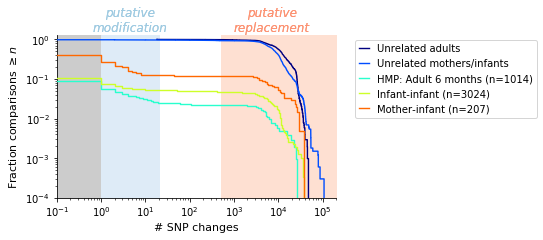

In [23]:
plt.show()
# fig_snp.savefig('%s/temporal_snp_changes_%s_pooled.pdf' % (config.analysis_directory, sweep_type),bbox_inches='tight')

In [14]:
from utils import temporal_changes_utils, config, sample_utils as su, parse_midas_data
from collections import defaultdict
import numpy as np
import pickle
import sys
from matplotlib import pyplot as plt

# Minimum coverage to consider sites
min_coverage = 20 # 20, 50, 75, 100

# Look at all allele frequency changes from very lax 0.45 -> 0.55
# I.e. frequency change of >= 10%
lower_threshold = 0.45
upper_threshold = 0.55

# Cohort list
cohorts = ['backhed', 'ferretti', 'yassour', 'shao', 'olm', 'hmp']

# Plot directory
plot_dir = "%s/snp_freq_changes/cov_%i/" % (config.analysis_directory, min_coverage)

# Species list
good_species_list = parse_midas_data.load_pickled_good_species_list()

snp_freq_deltas_dict = pickle.load(open("%s/pickles/snp_freq_deltas_alt/snp_freq_deltas_cov_%i_dict.pkl" % (config.data_directory, min_coverage), 'r'))
snp_freq_deltas_subject_dict = pickle.load(open("%s/pickles/snp_freq_deltas_alt/snp_freq_deltas_subject_cov_%i_dict.pkl" % (config.data_directory, min_coverage), "rb"))
snp_subject_samples_dict = pickle.load(open("%s/pickles/snp_subject_samples_dict.pkl" % (config.data_directory), "rb"))

IOError: [Errno 2] No such file or directory: '/u/home/d/daisyche/mother_infant/data//pickles/snp_freq_deltas_alt/snp_freq_deltas_cov_20_dict.pkl'

In [2]:
from utils import sample_utils as su

In [132]:
snp_freq_deltas_by_tp_type = defaultdict(list)
subjects_by_tp_type = defaultdict(set)

for species in snp_freq_deltas_subject_dict:
    for cohort in snp_freq_deltas_subject_dict[species]:
        for subject in snp_freq_deltas_subject_dict[species][cohort]:
            for tp_pair in snp_freq_deltas_subject_dict[species][cohort][subject]:
                freq_deltas = snp_freq_deltas_subject_dict[species][cohort][subject][tp_pair]
                tpa, tpb = tp_pair
                tp_type = tpa[0] + tpb[0]
                if tp_type == 'IM':
                    tp_type = 'MI'
                snp_freq_deltas_by_tp_type[tp_type] += freq_deltas
                subjects_by_tp_type[tp_type].add(subject)

for tp_type in ['AA', 'MM', 'MI', 'II']:
    print("%s: %i subjects" % (tp_type, len(subjects_by_tp_type[tp_type])))

subsample_count = len(subjects_by_tp_type['MI'])

subjects_by_tp_type_subsampled = defaultdict(set)

for tp_type in ['AA', 'MI', 'II']:
    all_samples = list(subjects_by_tp_type[tp_type])
    subsampled_subjects = np.random.choice(all_samples, subsample_count, replace = False)
    subjects_by_tp_type_subsampled[tp_type] = subsampled_subjects

snp_freq_deltas_by_tp_type_subsampled = defaultdict(list)

for species in snp_freq_deltas_subject_dict:
    for cohort in snp_freq_deltas_subject_dict[species]:
        for subject in snp_freq_deltas_subject_dict[species][cohort]:
            for tp_pair in snp_freq_deltas_subject_dict[species][cohort][subject]:
                freq_deltas = snp_freq_deltas_subject_dict[species][cohort][subject][tp_pair]
                tpa, tpb = tp_pair
                tp_type = tpa[0] + tpb[0]
                if tp_type == 'IM':
                    tp_type = 'MI'
                if subject in subjects_by_tp_type_subsampled[tp_type]:
                    snp_freq_deltas_by_tp_type_subsampled[tp_type] += freq_deltas

AA: 149 subjects
MM: 34 subjects
MI: 83 subjects
II: 592 subjects


In [22]:
# Instead subsample by QP sample pair
# describe QP pair by 3-tuple: (species, host, tp_pair)

snp_freq_deltas_by_tp_type = defaultdict(list)
qp_pairs_by_tp_type = defaultdict(set)

for species in snp_freq_deltas_subject_dict:
    for cohort in snp_freq_deltas_subject_dict[species]:
        for subject in snp_freq_deltas_subject_dict[species][cohort]:
            for tp_pair in snp_freq_deltas_subject_dict[species][cohort][subject]:
                freq_deltas = snp_freq_deltas_subject_dict[species][cohort][subject][tp_pair]
                tpa, tpb = tp_pair
                tp_type = tpa[0] + tpb[0]
                if tp_type == 'IM':
                    tp_type = 'MI'
                    tp_pair = (tpb, tpa)
                snp_freq_deltas_by_tp_type[tp_type] += freq_deltas
                qp_pair = (species, subject, tp_pair)
                qp_pairs_by_tp_type[tp_type].add(qp_pair)

for tp_type in ['AA', 'MM', 'MI', 'II']:
    print("%s: %i QP sample pairs" % (tp_type, len(qp_pairs_by_tp_type[tp_type])))

subsample_count = 50
num_trials = 100

bins = np.linspace(0.3 + (0.7/20), 1, num=19)

snp_freq_deltas_by_tp_type_subsampled_binned = {tp_type: [[] for _ in range(len(bins)+1)] for tp_type in ['AA', 'MI', 'II']}

for trial in range(num_trials):
    qp_pairs_by_tp_type_subsampled = defaultdict(set)

    for tp_type in ['AA', 'MI', 'II']:
        all_qp_pairs = np.array(list(qp_pairs_by_tp_type[tp_type]))
        all_qp_pair_idx = np.arange(len(all_qp_pairs))
        subsampled_qp_pair_idx = np.random.choice(all_qp_pair_idx, subsample_count, replace = False)
        subsampled_qp_pairs = all_qp_pairs[subsampled_qp_pair_idx]
        qp_pairs_by_tp_type_subsampled[tp_type] = subsampled_qp_pairs

    snp_freq_deltas_by_tp_type_subsampled = defaultdict(list)

    for species in snp_freq_deltas_subject_dict:
        for cohort in snp_freq_deltas_subject_dict[species]:
            for subject in snp_freq_deltas_subject_dict[species][cohort]:
                for tp_pair in snp_freq_deltas_subject_dict[species][cohort][subject]:
                    freq_deltas = snp_freq_deltas_subject_dict[species][cohort][subject][tp_pair]
                    tpa, tpb = tp_pair
                    tp_type = tpa[0] + tpb[0]
                    if tp_type == 'IM':
                        tp_type = 'MI'
                        tp_pair = (tpb, tpa)
                    qp_pair = (species, subject, tp_pair)
                    if qp_pair in qp_pairs_by_tp_type_subsampled[tp_type]:
                        snp_freq_deltas_by_tp_type_subsampled[tp_type] += freq_deltas
    
    for tp_type in snp_freq_deltas_by_tp_type_subsampled:
        freq_deltas = snp_freq_deltas_by_tp_type_subsampled[tp_type]
        bin_idx_counts = {idx: 0 for idx in list(range(len(bins)+1))}
        for idx in np.digitize(freq_deltas, bins):
            bin_idx_counts[idx] += 1
        # print(bin_idx_counts)
        for idx in bin_idx_counts:
            snp_freq_deltas_by_tp_type_subsampled_binned[tp_type][idx].append(bin_idx_counts[idx])

AA: 1047 QP sample pairs
MM: 81 QP sample pairs
MI: 220 QP sample pairs
II: 3498 QP sample pairs


In [6]:
# Calculate number of days for a timpeoint pair

mi_sample_day_dict = su.get_mi_sample_day_dict()

def sample_pair_to_days(sample1, sample2):
    days = mi_sample_day_dict[sample2] - mi_sample_day_dict[sample1]
    if days < 0:
        return np.abs(days)
    return days

# Rough approximation of HMP time intervals
def adult_tp_pair_to_days(tp_pair):
    tpa, tpb = tp_pair
    return np.abs(int(tpa[-1:]) - int(tpb[-1:]))*180

In [7]:
# Get num SNPs (in frequency range)/day

fig, ax = plt.subplots(2, 2, figsize=(10,8))
i, j = 0, 0

include_zeros = True

for freq_lower, freq_upper in [(0.8, 1.0), (0.6, 1.0), (0.4, 1.0), (0.4, 0.8)]:
    rates_by_tp_type = defaultdict(list)

    for species in snp_freq_deltas_subject_dict:
        for cohort in snp_freq_deltas_subject_dict[species]:
            for subject in snp_freq_deltas_subject_dict[species][cohort]:
                for tp_pair in snp_freq_deltas_subject_dict[species][cohort][subject]:
                    sample1, sample2 = snp_subject_samples_dict[subject][tp_pair]
                    orig_freq_deltas = snp_freq_deltas_subject_dict[species][cohort][subject][tp_pair]

                    tpa, tpb = tp_pair
                    tp_type = tpa[0] + tpb[0]
                    if tp_type == 'IM':
                        tp_type = 'MI'
                        tp_pair = (tpb, tpa)

                    freq_deltas = np.array(orig_freq_deltas)
                    freq_deltas_f1 = freq_deltas[freq_deltas>=freq_lower]
                    freq_deltas_f2 = freq_deltas_f1[freq_deltas_f1<=freq_upper]
                    num_sweeps = len(freq_deltas_f2)

                    if num_sweeps > 0 or include_zeros == True:
                        if tp_type in ['MM', 'II']:
                            try:
                                days = sample_pair_to_days(sample1, sample2)                
                                rates_by_tp_type[tp_type].append(float(num_sweeps)/days)
                            except:
                                print("Sample not in mi_sample_day_dict")
                        elif tp_type in ['AA']:
                            days = adult_tp_pair_to_days(tp_pair)
                            rates_by_tp_type[tp_type].append(float(num_sweeps)/days)
    
    # ax[i][j].set_yscale('log')
    tp_types = ['II', 'MM', 'AA']
    tp_type_labels = []

    rates = [rates_by_tp_type[tp_type] for tp_type in tp_types]
    for tp_type in tp_types:
        tp_type_labels.append('%s\nn=%i' % (tp_type, len(rates_by_tp_type[tp_type])))
        

    ax[i][j].boxplot(rates)
    ax[i][j].set_xticklabels(tp_type_labels)
    ax[i][j].set_ylabel("Sweeps per day (freq range: %.01f-%.01f)" % (freq_lower, freq_upper))
    ax[i][j].set_ylim((0, 0.1))
    
    i += 1 # 0,0 -> 1,0 -> 0,1 -> 1,1
    if i == 2:
        i = 0
        j += 1

ax[0][0].set_title("Estimated rates of evolutionary SNP modification (Min coverage: %i)" % min_coverage)
plt.show()

fig.savefig('%s/sweep_rates_include_zeros.pdf' % (plot_dir),bbox_inches='tight')

NameError: name 'snp_freq_deltas_subject_dict' is not defined

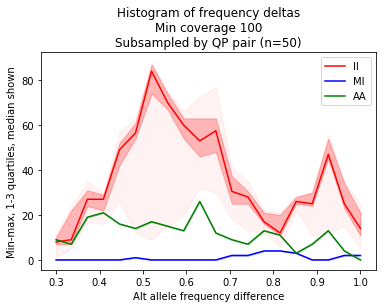

In [134]:
fig, ax = plt.subplots()

ordered_tp_type = ['II', 'MI', 'AA']
ordered_colors = ['red', 'blue', 'green']

for i in range(len(ordered_tp_type)):
    
    tp_type = ordered_tp_type[i]
    color = ordered_colors[i]
    
    freq_deltas = snp_freq_deltas_by_tp_type_subsampled_binned[tp_type]
    freqs = [0.3] + list(bins)
    ax.plot(freqs, np.quantile(freq_deltas, q=0.5, axis=1), color=color, label=tp_type)
    ax.fill_between(freqs, np.quantile(freq_deltas, q=0.25, axis=1), np.quantile(freq_deltas, q=0.75, axis=1), color=color, alpha=.25)
    ax.fill_between(freqs, np.quantile(freq_deltas, q=0, axis=1), np.quantile(freq_deltas, q=1, axis=1), color=color, alpha=.05)
    # plt.boxplot(snp_freq_deltas_by_tp_type_subsampled_binned['II'])

ax.set_title("Histogram of frequency deltas\nMin coverage %i\nSubsampled by QP pair (n=%i)" % (min_coverage, subsample_count))
ax.set_ylabel("Min-max, 1-3 quartiles, median shown")
ax.set_xlabel("Alt allele frequency difference")
ax.legend()

plt.show()

Saving figures...


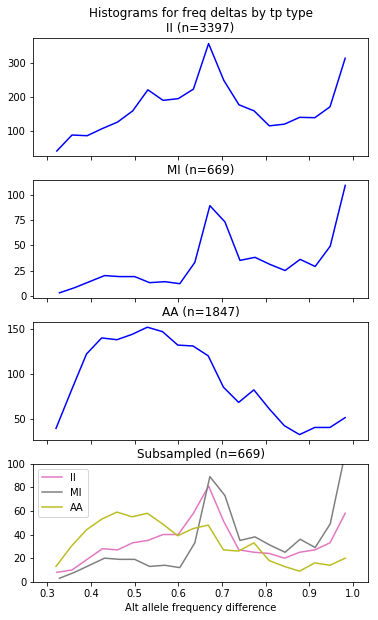

In [3]:
plot_dir = "%s/snp_freq_changes/cov_%i/" % (config.analysis_directory, min_coverage)

# ====================================================================
# Plot histogram of SNP freq deltas by tp type, stacked
# ====================================================================

tp_type_to_string = {'II': 'Infant-Infant', 'MI': 'Mother-Infant', 'MM': 'Mother-Mother', 'AA': 'Adult-Adult'}

fig_tp, ax_tp = plt.subplots(4, 1, figsize=(6,10), sharex=True)

ordered_tp_type = ['II', 'MI', 'AA']
subsample_count = len(snp_freq_deltas_by_tp_type['MI'])

ss_hists = []

for i in range(len(ordered_tp_type)):
	tp_type = ordered_tp_type[i]
	freq_deltas = snp_freq_deltas_by_tp_type[tp_type]
	bins = 20
	
	if len(freq_deltas) <= 1:
		continue
	
	n1,x,_ = plt.hist(freq_deltas, bins, histtype=u'step', alpha = 0.0)
	bin_centers = 0.5*(x[1:]+x[:-1])
	ax_tp[i].plot(bin_centers, n1, 'b-')
	
	ss_freq_deltas = np.random.choice(freq_deltas, subsample_count, replace=False)
	n2,x,_ = plt.hist(ss_freq_deltas, bins, histtype=u'step', alpha = 0.0)
	bin_centers = 0.5*(x[1:]+x[:-1])
	ss_hists.append((bin_centers, n2, tp_type))
	
	if i == 0:
		ax_tp[i].set_title('Histograms for freq deltas by tp type\n' +
		tp_type + " (n=%i)" % len(freq_deltas))
	else:
		ax_tp[i].set_title(tp_type + " (n=%i)" % len(freq_deltas))

ax_tp[3].set_title("Subsampled" + " (n=%i)" % subsample_count)
for bin_centers, n, tp_type in ss_hists:
    ax_tp[3].plot(bin_centers, n, '-', label=tp_type)

ax_tp[3].legend()

# ax_cohort_o.set_ylabel('Density')
ax_tp[3].set_xlabel('Alt allele frequency difference')
ax_tp[3].set_ylim((0, (int(max(n)/50)+1)*50))

sys.stderr.write("Saving figures...\n")
plt.show()
fig_tp.savefig('%s/freq_deltas_by_tp_type_stacked_subsampled_v2.png' % (plot_dir),bbox_inches='tight')

Saving figures...


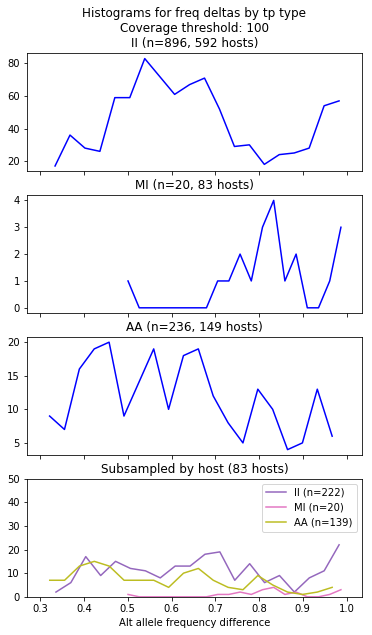

In [20]:
# same but subsampled by host

plot_dir = "%s/snp_freq_changes/cov_%i/" % (config.analysis_directory, min_coverage)

# ====================================================================
# Plot histogram of SNP freq deltas by tp type, stacked
# ====================================================================

tp_type_to_string = {'II': 'Infant-Infant', 'MI': 'Mother-Infant', 'MM': 'Mother-Mother', 'AA': 'Adult-Adult'}
ordered_tp_type = ['II', 'MI', 'AA']
subsample_count = len(subjects_by_tp_type['MI'])

fig_tp, ax_tp = plt.subplots(4, 1, figsize=(6,10), sharex=True)

for i in range(len(ordered_tp_type)):
	tp_type = ordered_tp_type[i]
	freq_deltas = snp_freq_deltas_by_tp_type[tp_type]
	bins = 20
	
	if len(freq_deltas) <= 1:
		continue
	
	n,x,_ = plt.hist(freq_deltas, bins, histtype=u'step', alpha = 0.0)
	bin_centers = 0.5*(x[1:]+x[:-1])
	ax_tp[i].plot(bin_centers, n, 'b-')
	
	if i == 0:
		ax_tp[i].set_title('Histograms for freq deltas by tp type\nCoverage threshold: %i\n' % min_coverage +
		tp_type + " (n=%i, %i hosts)" % (len(freq_deltas), len(subjects_by_tp_type[tp_type])))
	else:
		ax_tp[i].set_title(tp_type + " (n=%i, %i hosts)" % (len(freq_deltas), len(subjects_by_tp_type[tp_type])))

ax_tp[3].set_title("Subsampled by host" + " (%i hosts)" % subsample_count)
ns = []
for tp_type in ordered_tp_type:
    freq_deltas = snp_freq_deltas_by_tp_type_subsampled[tp_type]
    n,x,_ = plt.hist(freq_deltas, bins, histtype=u'step', alpha = 0.0)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax_tp[3].plot(bin_centers, n, '-', label=tp_type + (" (n=%i)" % sum(n)))
    ns += list(n)

ax_tp[3].legend()

# ax_cohort_o.set_ylabel('Density')
ax_tp[3].set_xlabel('Alt allele frequency difference')
ax_tp[3].set_ylim((0, (int(max(ns)/50)+1)*50))

sys.stderr.write("Saving figures...\n")
plt.show()
fig_tp.savefig('%s/freq_deltas_by_tp_type_stacked_subsampled_by_host.png' % (plot_dir),bbox_inches='tight')

In [7]:
max(ns)

117.0

In [13]:
threshold = 0.6

freq_partials = []
freq_fulls = []

tp_types_ordered = ['AA', 'MI', 'II']

for tp_type in tp_types_ordered:
    freq_deltas = snp_freq_deltas_by_tp_type[tp_type]
    num_partial = (np.array(freq_deltas) < 0.6).sum()
    num_full = len(freq_deltas) - num_partial
    freq_partials.append(float(num_partial)/len(freq_deltas))
    freq_fulls.append(float(num_full)/len(freq_deltas))

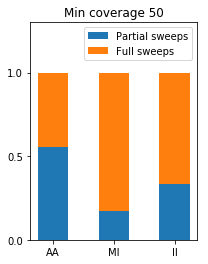

In [14]:
ind = np.arange(0, 3)
width = 0.5
fig = plt.figure(figsize=(3, 4))
plt.bar(ind, freq_partials, width, label='Partial sweeps')
plt.bar(ind, freq_fulls, width, bottom=freq_partials, label='Full sweeps')
plt.xticks(ind, tp_types_ordered)
plt.legend()
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim((0, 1.3))
plt.title("Min coverage %i" % min_coverage)
plt.show()
fig.savefig('%s/prop_partial_vs_full_sweeps.pdf' % plot_dir)

In [6]:
# Subsample infant-infant, adult-adult for 680 points
subsample_count = len(snp_freq_deltas_by_tp_type['MI'])

snp_freq_deltas_by_tp_type_subsampled = defaultdict(list)

for tp_type in ['AA', 'MI', 'II']:
    freq_deltas = snp_freq_deltas_by_tp_type[tp_type]
    new_freq_deltas = np.random.choice(freq_deltas, subsample_count, replace=False)
    snp_freq_deltas_by_tp_type_subsampled[tp_type] = new_freq_deltas

In [7]:
hist_by_tp_type = {}

for tp_type in ['AA', 'MI', 'II']:
    freq_deltas = snp_freq_deltas_by_tp_type_subsampled[tp_type]
    hist, _ = np.histogram(np.array(freq_deltas), bins=(0.3, 0.5, 0.8, 1.0))
    hist_by_tp_type[tp_type] = hist

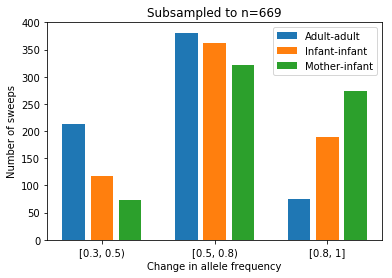

In [8]:
ind1 = [1,5,9]
ind2 = [2,6,10]
ind3 = [3,7,11]
fig = plt.figure()
plt.bar(ind1, hist_by_tp_type['AA'], label='Adult-adult')
plt.bar(ind2, hist_by_tp_type['II'], label='Infant-infant')
plt.bar(ind3, hist_by_tp_type['MI'], label='Mother-infant')
plt.xticks([2, 6, 10], ['[0.3, 0.5)', '[0.5, 0.8)', '[0.8, 1]'])
plt.xlabel("Change in allele frequency")
plt.ylabel("Number of sweeps")
plt.title("Subsampled to n=%i" % subsample_count)
plt.legend()
plt.show()
fig.savefig('%s/freq_delta_course_with_subsampling.pdf' % plot_dir)

In [9]:
# Subsample adult-adult for 1919 points
subsample_count = len(snp_freq_deltas_by_tp_type['AA'])

snp_freq_deltas_by_tp_type_subsampled = defaultdict(list)

for tp_type in ['AA', 'II']:
    freq_deltas = snp_freq_deltas_by_tp_type[tp_type]
    new_freq_deltas = np.random.choice(freq_deltas, subsample_count, replace=False)
    snp_freq_deltas_by_tp_type_subsampled[tp_type] = new_freq_deltas

In [10]:
hist_by_tp_type = {}

for tp_type in ['AA', 'II']:
    freq_deltas = snp_freq_deltas_by_tp_type_subsampled[tp_type]
    hist, _ = np.histogram(np.array(freq_deltas), bins=(0.3, 0.5, 0.8, 1.0))
    hist_by_tp_type[tp_type] = hist

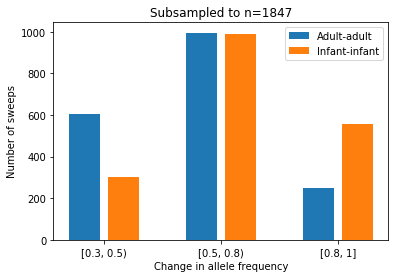

In [11]:
ind1 = [1,4,7]
ind2 = [2,5,8]
fig = plt.figure()
plt.bar(ind1, hist_by_tp_type['AA'], label='Adult-adult')
plt.bar(ind2, hist_by_tp_type['II'], label='Infant-infant')
plt.xticks([1.5, 4.5,7.5], ['[0.3, 0.5)', '[0.5, 0.8)', '[0.8, 1]'])
plt.xlabel("Change in allele frequency")
plt.ylabel("Number of sweeps")
plt.title("Subsampled to n=%i" % subsample_count)
plt.legend()
plt.show()
fig.savefig('%s/freq_delta_course_with_subsampling_no_MI.pdf' % plot_dir)

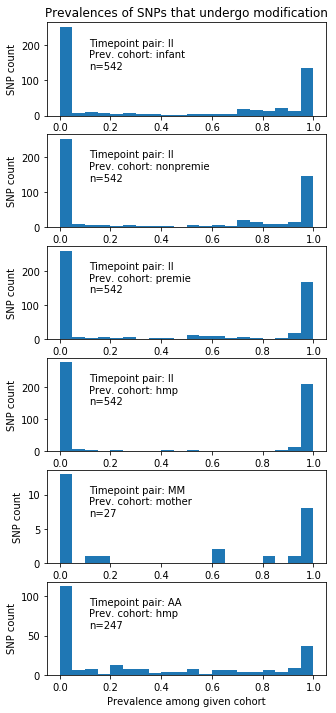

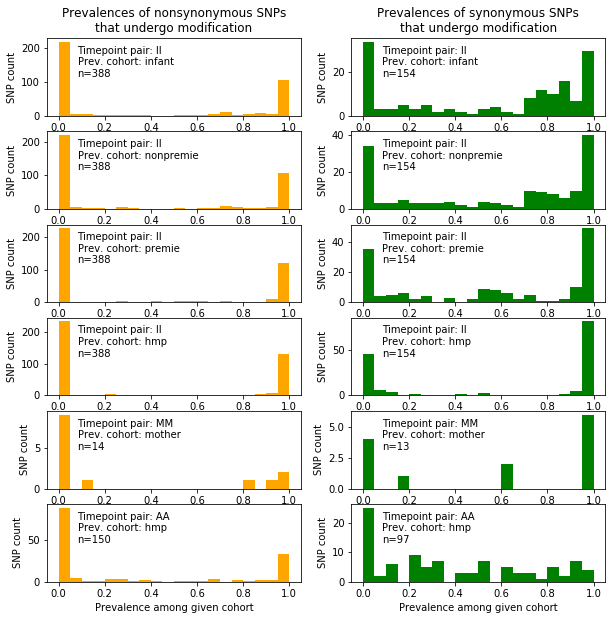

II,1D,infant: 0.5593
II,4D,infant: 0.2208
II,1D,nonpremie: 0.5644
II,4D,nonpremie: 0.2208
II,1D,premie: 0.5825
II,4D,premie: 0.2273
II,1D,hmp: 0.6005
II,4D,hmp: 0.2922
MM,1D,mother: 0.6429
MM,4D,mother: 0.3077
AA,1D,hmp: 0.5867
AA,4D,hmp: 0.2577
